In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [3]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================




In [4]:
#generated mixed state on wire 1, ancilla on 2
def generator(w):
    #U2(w,1,2)
    qml.RY(w[0], wires = 1)
    qml.CNOT(wires=[1,2])
    qml.RX(w[1], wires = 1)
    qml.RZ(w[2], wires=1)
    
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)
    
#receives state on wire 1 and measurement happens on wire 0
def discriminator(w):
    #U2(w,0,1)
    #U2(w,0,1)
    qml.CNOT(wires=[1,0])
    qml.RY(w[0], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(w[1], wires=1)
    qml.CNOT(wires=[1,0])
    qml.RZ(w[2], wires=0)
    qml.RX(w[3], wires=0)
    
#use same structure as for generator    
def real(w):
    #U2(w,1,2)
    qml.RY(w[0], wires = 1)
    qml.CNOT(wires=[1,2])
    qml.RX(w[1], wires = 1)
    qml.RZ(w[2], wires=1)

# Nodes

In [5]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))



QGAN cost functions
===================




In [6]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [7]:
np.random.seed(1)
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=3)

Generator and Discriminator parameter initialization

In [8]:
np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=3)
np.random.seed(17)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=4)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)
disc_weights=np.array(list(init_disc_weights), requires_grad=True)

We begin by creating the optimizer:


We train in turns. We expect around 250 turns to converge. Each turn consists of 5 discriminator steps and 1 generator step.

# Define some other metrics

In [9]:
dev_state = qml.device('default.qubit', wires=3)

In [10]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    real(w)
    return qml.density_matrix([1])


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.density_matrix([1])

In [11]:
def F_Tr_state(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    F = qt.fidelity(real_state,gen_state)
    d = qt.tracedist(real_state,gen_state)
    
    return (F,d,real_state,gen_state)

Visualize the real state, let's see if it's mixed

In [12]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

0.8759655184579888

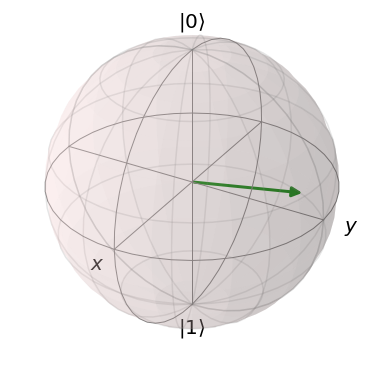

In [13]:
b = qt.Bloch()

b.add_states(real_state)
b.render()

In [14]:
opt1=qml.AdamOptimizer(stepsize=0.01)
opt2=qml.AdamOptimizer(stepsize=0.01)

# Training routine

In [ ]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity
States = []

#-------------------------------------------

costD = lambda: disc_cost(disc_weights, gen_weights)
costG = lambda: gen_cost(gen_weights, disc_weights)

for turn in range(250):

    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    
    for step in range(20): #The actual ratio should be 20 to 1, according to what we discussed
        
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_disc_current=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        
        #apply the optimization step
        disc_weights=np.array(opt1.apply_grad(grad_disc_current, disc_weights), requires_grad=True)

        if step == 19:
            costD_val = costD().numpy()
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)

    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)

    grad_gen_current=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    
    #generator has only one optimization step --> no history
    grad_gen_prev = grad_gen_current
    
    #do optimization step
    gen_weights=np.array(opt2.apply_grad(grad_gen_current, gen_weights), requires_grad=True)
   
    costG_val = costG().numpy()
    Gen_cost += [-costG_val] # P(R|G)
    
 

    F_Tr_st = F_Tr_state(real_params,gen_weights)
    
    
    F += [F_Tr_st[0]] #Fidelity
    Trace_d += [F_Tr_st[1]] #Trace distance
    States += [F_Tr_st[3]]
    
    print("P(R|R)-P(R|G): ", Disc_cost[-1])
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",F_Tr_st[0])
    print("Trace distance: ",F_Tr_st[1])
    print("------------------------------")

P(R|R)-P(R|G):  0.12001988291740417
P(R|G):  0.42031122744083405
Fidelity:  0.8767664183039934
Trace distance:  0.4208323869545638
------------------------------
P(R|R)-P(R|G):  0.16899211704730988
P(R|G):  0.44537708163261414
Fidelity:  0.8765158252027747
Trace distance:  0.42080471155377386
------------------------------
P(R|R)-P(R|G):  0.23180162906646729
P(R|G):  0.4533196687698364
Fidelity:  0.8762899898377666
Trace distance:  0.4208078452617063
------------------------------
P(R|R)-P(R|G):  0.2982395812869072
P(R|G):  0.4558338224887848
Fidelity:  0.8761103541740083
Trace distance:  0.4207649116990475
------------------------------
P(R|R)-P(R|G):  0.3540662080049515
P(R|G):  0.466351255774498
Fidelity:  0.8760231941564496
Trace distance:  0.42056963590677504
------------------------------
P(R|R)-P(R|G):  0.39076845347881317
P(R|G):  0.4778985530138016
Fidelity:  0.876025180329624
Trace distance:  0.4202263173577012
------------------------------
P(R|R)-P(R|G):  0.4093646518886089

P(R|R)-P(R|G):  0.36442602425813675
P(R|G):  0.5500627309083939
Fidelity:  0.9037664301301617
Trace distance:  0.3615892010510116
------------------------------
P(R|R)-P(R|G):  0.36158911511301994
P(R|G):  0.5523123145103455
Fidelity:  0.9051665630827672
Trace distance:  0.35863593185562803
------------------------------
P(R|R)-P(R|G):  0.3586358167231083
P(R|G):  0.5546685457229614
Fidelity:  0.9066126553864967
Trace distance:  0.35556354012496233
------------------------------
P(R|R)-P(R|G):  0.35556354373693466
P(R|G):  0.5571342706680298
Fidelity:  0.9081046633157484
Trace distance:  0.35236915721991696
------------------------------
P(R|R)-P(R|G):  0.35236912220716476
P(R|G):  0.5597066581249237
Fidelity:  0.9096423959952573
Trace distance:  0.3490500209975365
------------------------------
P(R|R)-P(R|G):  0.34904979914426804
P(R|G):  0.5623778402805328
Fidelity:  0.9112254944119966
Trace distance:  0.34560350928979433
------------------------------
P(R|R)-P(R|G):  0.3456032052636

P(R|R)-P(R|G):  0.07885890826582909
P(R|G):  0.854484923183918
Fidelity:  0.9924667129350244
Trace distance:  0.0739544121329645
------------------------------
P(R|R)-P(R|G):  0.07394632697105408
P(R|G):  0.8613152876496315
Fidelity:  0.9932333567363989
Trace distance:  0.0694496643675972
------------------------------
P(R|R)-P(R|G):  0.0694417729973793
P(R|G):  0.8655153661966324
Fidelity:  0.9939376748833548
Trace distance:  0.06532674412061015
------------------------------
P(R|R)-P(R|G):  0.0653182901442051
P(R|G):  0.8675802946090698
Fidelity:  0.9945859588956104
Trace distance:  0.06153693258281792
------------------------------
P(R|R)-P(R|G):  0.06152816489338875
P(R|G):  0.8676189631223679
Fidelity:  0.9951848893443161
Trace distance:  0.058006731681932364
------------------------------
P(R|R)-P(R|G):  0.057998497039079666
P(R|G):  0.8659513741731644
Fidelity:  0.9957409471812972
Trace distance:  0.05464511386298036
------------------------------
P(R|R)-P(R|G):  0.0546378828585

In [ ]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

In [ ]:
print(min(Trace_d))
print(max(Trace_d[160:200]))

In [ ]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([-0.1,1.1])
plt.xlabel('Turns (20D+1G)') 
plt.title("1-qubit mixed metrics")
plt.legend()
plt.savefig('1qubit adam.pdf', format='pdf')

In [ ]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

b = qt.Bloch()

b.add_states(real_state)
b.render()

In [ ]:
gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
(gen_state*gen_state).tr()

b = qt.Bloch()

b.add_states(gen_state)
b.render()

In [ ]:
b = qt.Bloch()
b.point_marker=['o']
b.point_color=['r']
b.vector_color=['r', 'b']
final_real = F_Tr_state(real_params,gen_weights)[2]
final_gen =  F_Tr_state(real_params,gen_weights)[3]
b.add_states(final_real)
b.add_states(final_gen)
b.add_states(States, 'point')
b.render()
plt.savefig('bloch adam.pdf', format='pdf')

# Best Run

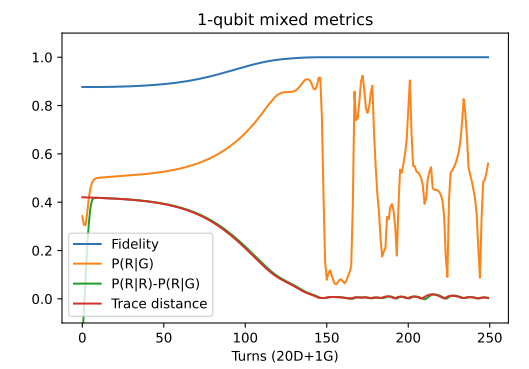

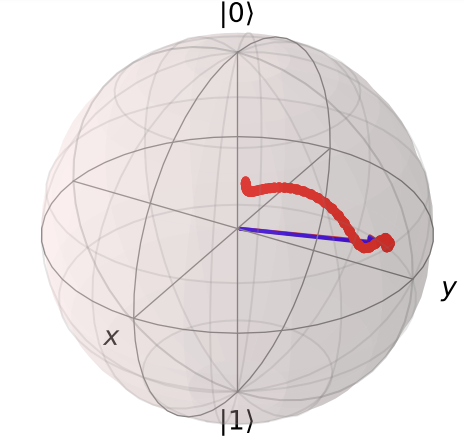

optimal parameters:
- G&R = min Ansatz
- D = U2
- learning rate = 0.01
- ratio = 20:1
- min(Trace_dist) = 0.00048